In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set dataset paths
data_dir = "/content/drive/MyDrive/dataset/signatures/"
img_size = (128, 128)  # Resize images
batch_size = 32
num_classes = 10  # 10 signature classes

In [23]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,      # Reduced rotation (preserves structure)
    width_shift_range=0.05, # Small horizontal shift
    height_shift_range=0.05,# Small vertical shift
    shear_range=0.1,        # Reduced shear
    zoom_range=0.1,         # Slight zoom
    horizontal_flip=False,  # No flipping (signatures have direction)
    validation_split=0.2
)

dataset_path = "/content/drive/MyDrive/dataset/signatures/"  # 🔴 Update this path if incorrect

# ============================
# 🏋️‍♂️ Load Data
# ============================
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 160 images belonging to 10 classes.
Found 40 images belonging to 10 classes.


In [25]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

# Freeze base model layers (to use pre-trained features)
base_model.trainable = False

# ============================
# 🔧 Custom Layers
# ============================
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),   # Prevent overfitting
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')  # 🔴 Ensure you have 10 classes
])

# ============================
# 🔥 Compile Model (Fixed LR)
# ============================
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # 🔥 Increased LR
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # 🔴 Reduce from 50 to 30 (overfitting risk)
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.0982 - loss: 3.4728 - val_accuracy: 0.3250 - val_loss: 1.9434
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 769ms/step - accuracy: 0.2940 - loss: 2.3038 - val_accuracy: 0.5500 - val_loss: 1.4723
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4178 - loss: 1.6368 - val_accuracy: 0.8000 - val_loss: 1.1105
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 750ms/step - accuracy: 0.6224 - loss: 1.0496 - val_accuracy: 0.7250 - val_loss: 1.0122
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 764ms/step - accuracy: 0.6751 - loss: 0.8773 - val_accuracy: 0.7500 - val_loss: 0.8233
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7719 - loss: 0.7554 - val_accuracy: 0.8750 - val_loss: 0.7206
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 738ms/step - accuracy: 0.8432 - loss: 0.5764 - val_accuracy: 0.8500 - val_loss: 0.6929
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 875ms/step - accuracy: 0.8417 - loss: 0.5185 - val_accuracy: 0.8500 - val_loss: 0.5227


In [27]:
# Save Model
model.save('signature_forgery_model.keras')

In [28]:
# Evaluate Model
loss, acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {acc * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.8313 - loss: 0.4538
Validation Accuracy: 82.50%


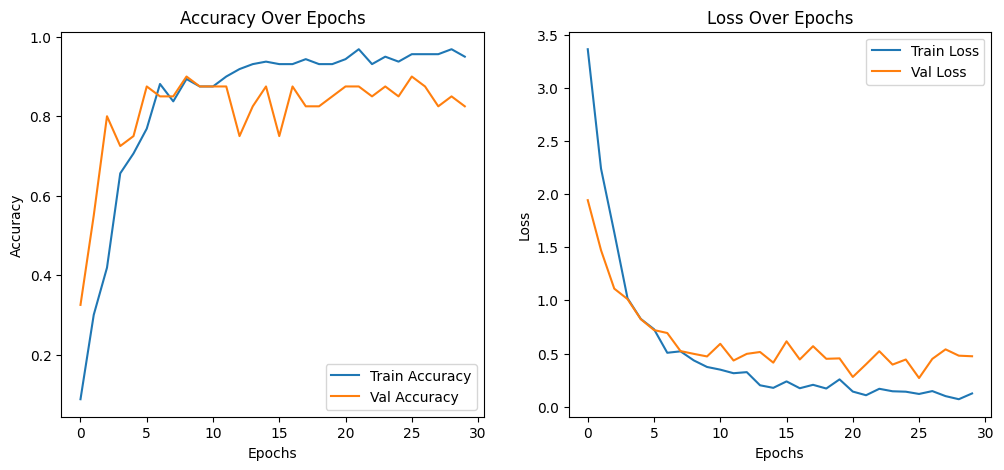

🔥 Final Train Accuracy: 95.00%
🔥 Final Validation Accuracy: 82.50%
Class Labels: {'sig_1': 0, 'sig_10': 1, 'sig_2': 2, 'sig_3': 3, 'sig_4': 4, 'sig_5': 5, 'sig_6': 6, 'sig_7': 7, 'sig_8': 8, 'sig_9': 9}


In [29]:
# ============================
# 📊 Plot Accuracy & Loss
# ============================
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# ============================
# 🎯 Evaluate Final Accuracy
# ============================
final_train_acc = history.history['accuracy'][-1] * 100
final_val_acc = history.history['val_accuracy'][-1] * 100
print(f"🔥 Final Train Accuracy: {final_train_acc:.2f}%")
print(f"🔥 Final Validation Accuracy: {final_val_acc:.2f}%")

# ============================
# 🔍 Check Class Labels (for debugging)
# ============================
print("Class Labels:", train_generator.class_indices)